# In this notebook I will present my models which used for predictions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

In [2]:
df = pd.read_csv('../creditcard.csv')

In [3]:
X = df.iloc[:, :-1]
y = df['Class']

In [4]:
und = RandomUnderSampler()
X_und, y_und = und.fit_resample(X, y)

In [5]:
Counter(y_und)

Counter({0: 492, 1: 492})

In [6]:
# Lets concat undersampled X and y
df_und = pd.concat([X_und, y_und], axis=1)
df_und.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,43472.0,-2.703379,-2.765187,1.634296,-0.921596,2.548505,-3.138880,-1.394357,0.030538,-1.443436,...,-0.143472,-0.962849,0.347564,0.374059,0.456712,0.924996,-0.174454,0.102622,13.94,0
1,133456.0,2.128006,-1.815790,-0.232000,-1.739638,-1.561162,0.581367,-1.903957,0.244592,-0.915388,...,-0.043637,0.246593,0.268189,0.200817,-0.532771,-0.256869,0.052548,-0.027736,64.30,0
2,61869.0,-0.805320,-0.979016,2.281645,-1.474275,-0.873525,0.729081,-0.033706,0.185215,0.171499,...,0.287699,0.896826,-0.069809,-0.419164,0.306186,-0.117887,-0.093309,-0.124221,145.59,0
3,12443.0,1.105762,-0.616627,0.816607,0.339242,-0.900344,0.138514,-0.719458,0.063580,2.698915,...,-0.399295,-0.884769,-0.075285,-0.466664,0.157056,0.950496,-0.084727,0.012128,94.85,0
4,49506.0,-1.305315,-0.801638,2.517726,-0.561589,-1.311136,0.589640,0.660796,-0.744293,0.225922,...,-0.110095,0.694828,0.140696,0.437557,-0.223559,-0.281383,-0.974422,-0.238621,160.00,0


## Lets build our first Pipeline

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, f1_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import BaggingClassifier

In [15]:
algos = {
    'DecisionTreeClassifier' : DecisionTreeClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'GaussianNB' : GaussianNB(),
    'LogisticRegression' : LogisticRegression(max_iter=200),
#     'BaggingClassifier' : BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50)
}

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_und, y_und)

In [17]:
for name, classifier in algos.items():
    pipeline = Pipeline(steps=[
        ('classifier', classifier)
    ])
    pipeline.fit(X_train, y_train)
    y_predicted=pipeline.predict_proba(X_test)
    print(name,'ROC SCORE', roc_auc_score(y_test, y_predicted[:, 1]))

DecisionTreeClassifier ROC SCORE 0.8937520661157025
KNeighborsClassifier ROC SCORE 0.668198347107438
GaussianNB ROC SCORE 0.9586776859504131
LogisticRegression ROC SCORE 0.969785123966942


### As we can see Gaussian Naive Bayes along side with Logistic regression performed well on the data
### Now I will try ensemble methods

In [18]:
ensem = {
    'RandomForestClassifier' : RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'LGBMClassifier' : LGBMClassifier(),
    'CatBoostClassifier' : CatBoostClassifier(verbose=False),
}

In [19]:
for name, classifier in ensem.items():
    pipe_en = Pipeline(steps=[
        ('classifier', classifier)
    ])
    pipe_en.fit(X_train, y_train)
    y_predicted=pipe_en.predict_proba(X_test)
    print(name,'ROC SCORE', roc_auc_score(y_test, y_predicted[:, 1]))

RandomForestClassifier ROC SCORE 0.9723305785123966
GradientBoostingClassifier ROC SCORE 0.9738181818181818
LGBMClassifier ROC SCORE 0.979702479338843
CatBoostClassifier ROC SCORE 0.9795702479338844


## The accuracy might change depending on train test split so we will try cross validation 

In [20]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [22]:
models = {
    'LogisticRegression' : LogisticRegression(max_iter=200 ),
    'RandomForestClassifier' : RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'LGBMClassifier' : LGBMClassifier(),
    'CatBoostClassifier' : CatBoostClassifier(verbose=False),
    'BaggingClassifier': BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50)
}

In [23]:
results = []
names = []

for name, model in models.items():
    skfold = StratifiedKFold(n_splits=10)
    cv_results = cross_val_score(model, X_und, y_und, cv=skfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

LogisticRegression: 0.960918 (0.040008)
RandomForestClassifier: 0.970503 (0.029596)
GradientBoostingClassifier: 0.962829 (0.031238)
LGBMClassifier: 0.968870 (0.029562)
CatBoostClassifier: 0.973272 (0.027171)
BaggingClassifier: 0.968474 (0.031461)


In [25]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

## In the EDA notebook we saw that dimensionality reduction techniques were useful. Let's try predicting on them

In [17]:
X_new = df_und[['V12', 'V14', 'V10', 'V11', 'V17']]
y_new = df_und.iloc[:, -1]

In [18]:
results = []
names = []

for name, model in models.items():
    skfold = StratifiedKFold(n_splits=10)
    pipeline = Pipeline(steps=[
        ('dim_red', PCA()),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    cv_results = cross_val_score(pipeline, X_new, y_new, cv=skfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

GaussianNB: 0.959539 (0.032323)


C:\Users\egadi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression: 0.955950 (0.026540)
RandomForestClassifier: 0.957468 (0.035475)
GradientBoostingClassifier: 0.948928 (0.036886)
LGBMClassifier: 0.952370 (0.031205)
CatBoostClassifier: 0.955455 (0.028704)


In [19]:
results = []
names = []

for name, model in models.items():
    skfold = StratifiedKFold(n_splits=10)
    pipeline = Pipeline(steps=[
        ('dim_red', PCA()),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    cv_results = cross_val_score(pipeline, X_new, y_new, cv=skfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

GaussianNB: 0.959539 (0.032323)


C:\Users\egadi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression: 0.955950 (0.026540)
RandomForestClassifier: 0.958044 (0.034374)
GradientBoostingClassifier: 0.949633 (0.037050)
LGBMClassifier: 0.952370 (0.031205)
CatBoostClassifier: 0.955455 (0.028704)


## Now try neural networks using tensorflow

In [87]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

## Before applying tensorflow lets scale the data

In [54]:
X=df.drop(columns=["Class"])
y=df["Class"]

In [55]:
names=X.columns
scaled_df = preprocessing.scale(X)
scaled_df = pd.DataFrame(scaled_df,columns=names)
scaled_df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.996583,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,...,0.326118,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,0.244964
1,-1.996583,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,...,-0.089611,-0.307377,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,-0.342475
2,-1.996562,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,...,0.680975,0.337632,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,1.160686
3,-1.996562,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,...,-0.269855,-0.147443,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,0.140534
4,-1.996541,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,...,0.529939,-0.012839,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,-0.073403


In [73]:
scaled_df.shape

(284807, 30)

In [104]:
under = RandomUnderSampler()
X_under, y_under = under.fit_resample(scaled_df, y)
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under)

In [105]:
Counter(y_under)

Counter({0: 492, 1: 492})

In [106]:
X_under.shape

(984, 30)

In [77]:
clf = LogisticRegression(solver = 'lbfgs')
clf.fit(X_train, y_train)
test_pred = clf.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, test_pred))

0.9756679077666732


In [78]:
model = Sequential()
model.add(Dense(X_train.shape[1], activation = 'relu', input_dim = X_train.shape[1]))
model.add(BatchNormalization())

model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation = 'sigmoid'))

In [79]:
optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy')

In [80]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)

In [81]:
history = model.fit(x=X_train, y=y_train, batch_size = 256, epochs=200,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop])

Epoch 1/200
5/5 [==============================] - 2s 82ms/step - loss: 1.0621 - val_loss: 1.0231
Epoch 2/200
5/5 [==============================] - 0s 17ms/step - loss: 0.9871 - val_loss: 0.9470
Epoch 3/200
5/5 [==============================] - 0s 17ms/step - loss: 0.9411 - val_loss: 0.8886
Epoch 4/200
5/5 [==============================] - 0s 20ms/step - loss: 0.9846 - val_loss: 0.8449
Epoch 5/200
5/5 [==============================] - 0s 20ms/step - loss: 0.9701 - val_loss: 0.8089
Epoch 6/200
5/5 [==============================] - 0s 19ms/step - loss: 0.9275 - val_loss: 0.7781
Epoch 7/200
5/5 [==============================] - 0s 19ms/step - loss: 0.9082 - val_loss: 0.7509
Epoch 8/200
5/5 [==============================] - 0s 18ms/step - loss: 0.8619 - val_loss: 0.7251
Epoch 9/200
5/5 [==============================] - 0s 17ms/step - loss: 0.8809 - val_loss: 0.7022
Epoch 10/200
5/5 [==============================] - 0s 20ms/step - loss: 0.8441 - val_loss: 0.6810
Epoch 11/200
5/5 [=

Epoch 84/200
5/5 [==============================] - 0s 23ms/step - loss: 0.3313 - val_loss: 0.1952
Epoch 85/200
5/5 [==============================] - 0s 22ms/step - loss: 0.3158 - val_loss: 0.1943
Epoch 86/200
5/5 [==============================] - 0s 23ms/step - loss: 0.3038 - val_loss: 0.1933
Epoch 87/200
5/5 [==============================] - 0s 23ms/step - loss: 0.3510 - val_loss: 0.1925
Epoch 88/200
5/5 [==============================] - 0s 28ms/step - loss: 0.2942 - val_loss: 0.1916
Epoch 89/200
5/5 [==============================] - 0s 22ms/step - loss: 0.2850 - val_loss: 0.1907
Epoch 90/200
5/5 [==============================] - 0s 22ms/step - loss: 0.3413 - val_loss: 0.1897
Epoch 91/200
5/5 [==============================] - 0s 21ms/step - loss: 0.3230 - val_loss: 0.1887
Epoch 92/200
5/5 [==============================] - 0s 21ms/step - loss: 0.3076 - val_loss: 0.1879
Epoch 93/200
5/5 [==============================] - 0s 22ms/step - loss: 0.3036 - val_loss: 0.1872
Epoch 94/2

5/5 [==============================] - 0s 16ms/step - loss: 0.2257 - val_loss: 0.1583
Epoch 167/200
5/5 [==============================] - 0s 20ms/step - loss: 0.2103 - val_loss: 0.1582
Epoch 168/200
5/5 [==============================] - 0s 21ms/step - loss: 0.2113 - val_loss: 0.1581
Epoch 169/200
5/5 [==============================] - 0s 19ms/step - loss: 0.2260 - val_loss: 0.1580
Epoch 170/200
5/5 [==============================] - 0s 15ms/step - loss: 0.2260 - val_loss: 0.1578
Epoch 171/200
5/5 [==============================] - 0s 23ms/step - loss: 0.2034 - val_loss: 0.1576
Epoch 172/200
5/5 [==============================] - 0s 20ms/step - loss: 0.1972 - val_loss: 0.1574
Epoch 173/200
5/5 [==============================] - 0s 17ms/step - loss: 0.1902 - val_loss: 0.1573
Epoch 174/200
5/5 [==============================] - 0s 18ms/step - loss: 0.2217 - val_loss: 0.1574
Epoch 175/200
5/5 [==============================] - 0s 14ms/step - loss: 0.2297 - val_loss: 0.1572
Epoch 176/200


Text(0.5, 1.0, 'Loss for both Training and Validation')

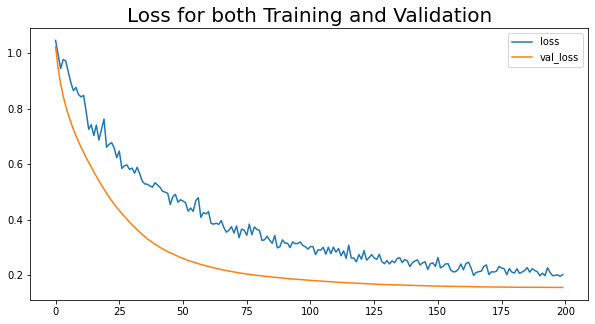

In [82]:
evaluation_metrics=pd.DataFrame(model.history.history)
evaluation_metrics.plot(figsize=(10,5))
plt.title("Loss for both Training and Validation", size = 20)

In [83]:
test_pred = model.predict(X_test)
print(roc_auc_score(y_test, test_pred))

0.9772682735645699


In [70]:
test_pred = model.predict(X_test)
print(roc_auc_score(y_test, test_pred))

0.9772245762711864


In [89]:
y_pred = model.predict_classes(X_test)

C:\Users\egadi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [90]:
cm_nn=confusion_matrix(y_test, y_pred)
cm_nn

array([[240,   3],
       [ 18, 108]], dtype=int64)

Text(0.5, 1.0, 'Confusion Matrix Plotting for Neural Network model')

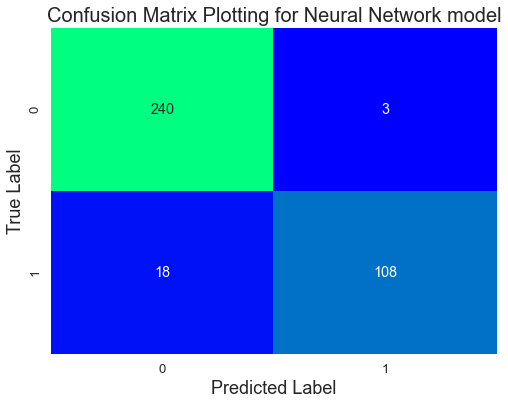

In [91]:
plt.figure(figsize=(8,6))
sns.set(font_scale=1.2)
sns.heatmap(cm_nn, annot=True, fmt = 'g', cmap="winter", cbar = False)
plt.xlabel("Predicted Label", size = 18)
plt.ylabel("True Label", size = 18)
plt.title("Confusion Matrix Plotting for Neural Network model", size = 20)

# Hyperparameter optimization with Optuna library 

In [120]:
import optuna
import sklearn.datasets
import sklearn.ensemble
import sklearn.model_selection
import sklearn.svm
import lightgbm as lgb
import catboost as cb

In [114]:
# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
#     iris = sklearn.datasets.load_iris()
#     x, y = iris.data, iris.target

    classifier_name = trial.suggest_categorical("classifier", ["SVC", "RandomForest"])
    if classifier_name == "SVC":
        svc_c = trial.suggest_float("svc_c", 1e-10, 1e10, log=True)
        classifier_obj = sklearn.svm.SVC(C=svc_c, gamma="auto")
    else:
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
        classifier_obj = sklearn.ensemble.RandomForestClassifier(
            max_depth=rf_max_depth, n_estimators=10
        )

    score = sklearn.model_selection.cross_val_score(classifier_obj, X_under, y_under, n_jobs=-1, cv=3, scoring='roc_auc')
    accuracy = score.mean()
    return accuracy


In [115]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_trial)

[I 2021-04-23 10:55:23,432] A new study created in memory with name: no-name-6216e590-8a33-4bbf-8f7f-ed1f29566523
[I 2021-04-23 10:55:23,551] Trial 0 finished with value: 0.956028157842554 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 5}. Best is trial 0 with value: 0.956028157842554.
[I 2021-04-23 10:55:23,669] Trial 1 finished with value: 0.9557059290105095 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 19}. Best is trial 0 with value: 0.956028157842554.
[I 2021-04-23 10:55:23,793] Trial 2 finished with value: 0.9528926234384295 and parameters: {'classifier': 'SVC', 'svc_c': 31.569817286180786}. Best is trial 0 with value: 0.956028157842554.
[I 2021-04-23 10:55:23,917] Trial 3 finished with value: 0.9609049672813802 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 7}. Best is trial 3 with value: 0.9609049672813802.
[I 2021-04-23 10:55:24,019] Trial 4 finished with value: 0.9603038865754511 and parameters: {'classifier': 'RandomForest', '

[I 2021-04-23 10:55:27,209] Trial 40 finished with value: 0.9661225956771763 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 4}. Best is trial 39 with value: 0.9684587547094984.
[I 2021-04-23 10:55:27,280] Trial 41 finished with value: 0.9565424846321634 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 4}. Best is trial 39 with value: 0.9684587547094984.
[I 2021-04-23 10:55:27,371] Trial 42 finished with value: 0.9515417410271664 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 2}. Best is trial 39 with value: 0.9684587547094984.
[I 2021-04-23 10:55:27,488] Trial 43 finished with value: 0.9574224172119769 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 5}. Best is trial 39 with value: 0.9684587547094984.
[I 2021-04-23 10:55:27,560] Trial 44 finished with value: 0.9525394110648424 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 3}. Best is trial 39 with value: 0.9684587547094984.
[I 2021-04-23 10:55:27,628] Trial 4

[I 2021-04-23 10:55:30,409] Trial 80 finished with value: 0.9370724271267102 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 2}. Best is trial 46 with value: 0.9695679654967281.
[I 2021-04-23 10:55:30,480] Trial 81 finished with value: 0.9697414733293673 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 3}. Best is trial 81 with value: 0.9697414733293673.
[I 2021-04-23 10:55:30,544] Trial 82 finished with value: 0.9577322526274044 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 3}. Best is trial 81 with value: 0.9697414733293673.
[I 2021-04-23 10:55:30,593] Trial 83 finished with value: 0.9488399762046401 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 2}. Best is trial 81 with value: 0.9697414733293673.
[I 2021-04-23 10:55:30,660] Trial 84 finished with value: 0.9655958754709499 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 2}. Best is trial 81 with value: 0.9697414733293673.
[I 2021-04-23 10:55:30,727] Trial 8

FrozenTrial(number=81, values=[0.9697414733293673], datetime_start=datetime.datetime(2021, 4, 23, 10, 55, 30, 410471), datetime_complete=datetime.datetime(2021, 4, 23, 10, 55, 30, 480150), params={'classifier': 'RandomForest', 'rf_max_depth': 3}, distributions={'classifier': CategoricalDistribution(choices=('SVC', 'RandomForest')), 'rf_max_depth': IntLogUniformDistribution(high=32, low=2, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=81, state=TrialState.COMPLETE, value=None)


In [112]:
def objective(trial):
#     data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
    train_x, valid_x, train_y, valid_y = train_test_split(X_under, y_under, test_size=0.25)
    dtrain = lgb.Dataset(train_x, label=train_y)

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.roc_auc_score(valid_y, pred_labels)
    return accuracy

In [113]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-04-23 10:55:04,321] A new study created in memory with name: no-name-d81cec3d-3e25-4c38-a46a-384a477548f8
[I 2021-04-23 10:55:04,459] Trial 0 finished with value: 0.9473162347964039 and parameters: {'lambda_l1': 2.5465877373876843e-05, 'lambda_l2': 5.742957237112198e-06, 'num_leaves': 18, 'feature_fraction': 0.4483095415869452, 'bagging_fraction': 0.8921931291642664, 'bagging_freq': 6, 'min_child_samples': 41}. Best is trial 0 with value: 0.9473162347964039.
[I 2021-04-23 10:55:04,530] Trial 1 finished with value: 0.9130880698736188 and parameters: {'lambda_l1': 0.06178762384353401, 'lambda_l2': 7.726522412129233, 'num_leaves': 210, 'feature_fraction': 0.6567211724073977, 'bagging_fraction': 0.42967073039394565, 'bagging_freq': 6, 'min_child_samples': 84}. Best is trial 0 with value: 0.9473162347964039.
[I 2021-04-23 10:55:04,646] Trial 2 finished with value: 0.9432539682539682 and parameters: {'lambda_l1': 1.6797050879539614e-08, 'lambda_l2': 0.4630844497497064, 'num_leaves': 

[I 2021-04-23 10:55:09,012] Trial 22 finished with value: 0.9244570974576272 and parameters: {'lambda_l1': 1.0837318058419702e-08, 'lambda_l2': 3.84544168467629e-05, 'num_leaves': 4, 'feature_fraction': 0.85578629917114, 'bagging_fraction': 0.8330608476598809, 'bagging_freq': 2, 'min_child_samples': 18}. Best is trial 9 with value: 0.9586202330508475.
[I 2021-04-23 10:55:09,268] Trial 23 finished with value: 0.9431517715494447 and parameters: {'lambda_l1': 2.8127459040575e-07, 'lambda_l2': 0.000334102791166042, 'num_leaves': 37, 'feature_fraction': 0.7399099669686995, 'bagging_fraction': 0.7515500714666219, 'bagging_freq': 3, 'min_child_samples': 35}. Best is trial 9 with value: 0.9586202330508475.
[I 2021-04-23 10:55:09,428] Trial 24 finished with value: 0.9339285714285713 and parameters: {'lambda_l1': 6.233675781745595e-08, 'lambda_l2': 2.7344145414972593e-06, 'num_leaves': 66, 'feature_fraction': 0.9519973746312201, 'bagging_fraction': 0.9025983463703291, 'bagging_freq': 1, 'min_chi

[I 2021-04-23 10:55:14,181] Trial 45 finished with value: 0.9190904283447912 and parameters: {'lambda_l1': 1.2900401677414448e-07, 'lambda_l2': 2.0269841435321205e-06, 'num_leaves': 115, 'feature_fraction': 0.8819573035191441, 'bagging_fraction': 0.6537890933719718, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 34 with value: 0.9627142195460862.
[I 2021-04-23 10:55:14,403] Trial 46 finished with value: 0.926829268292683 and parameters: {'lambda_l1': 2.320124266644594e-06, 'lambda_l2': 1.19047702908117e-07, 'num_leaves': 31, 'feature_fraction': 0.7274568817318257, 'bagging_fraction': 0.5915529790637152, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 34 with value: 0.9627142195460862.
[I 2021-04-23 10:55:14,618] Trial 47 finished with value: 0.934690639873083 and parameters: {'lambda_l1': 3.7994099390207763e-05, 'lambda_l2': 2.4611224611642914e-08, 'num_leaves': 78, 'feature_fraction': 0.7689248205302663, 'bagging_fraction': 0.758918637144562, 'bagging_freq': 7, 

[I 2021-04-23 10:55:18,926] Trial 68 finished with value: 0.9634146341463417 and parameters: {'lambda_l1': 5.739258906689734e-06, 'lambda_l2': 1.266488971587882e-05, 'num_leaves': 11, 'feature_fraction': 0.6985910297159353, 'bagging_fraction': 0.50236305624781, 'bagging_freq': 1, 'min_child_samples': 62}. Best is trial 68 with value: 0.9634146341463417.
[I 2021-04-23 10:55:19,045] Trial 69 finished with value: 0.9471544715447154 and parameters: {'lambda_l1': 7.052275450294143e-06, 'lambda_l2': 5.713218137763786e-05, 'num_leaves': 12, 'feature_fraction': 0.580787223358135, 'bagging_fraction': 0.593430249437928, 'bagging_freq': 1, 'min_child_samples': 71}. Best is trial 68 with value: 0.9634146341463417.
[I 2021-04-23 10:55:19,169] Trial 70 finished with value: 0.9246411483253589 and parameters: {'lambda_l1': 3.542876844612373e-05, 'lambda_l2': 3.49014903848342e-08, 'num_leaves': 6, 'feature_fraction': 0.5126953113161011, 'bagging_fraction': 0.5096002831682639, 'bagging_freq': 1, 'min_ch

[I 2021-04-23 10:55:21,942] Trial 91 finished with value: 0.9300239234449761 and parameters: {'lambda_l1': 1.2927827857494518e-06, 'lambda_l2': 1.1966232604605025e-05, 'num_leaves': 43, 'feature_fraction': 0.6966249685566004, 'bagging_fraction': 0.633900923869775, 'bagging_freq': 1, 'min_child_samples': 59}. Best is trial 71 with value: 0.9791666666666667.
[I 2021-04-23 10:55:22,075] Trial 92 finished with value: 0.9255730277185501 and parameters: {'lambda_l1': 5.895601698702159e-07, 'lambda_l2': 4.7955316639052805e-05, 'num_leaves': 38, 'feature_fraction': 0.7103048438333033, 'bagging_fraction': 0.6151857179228062, 'bagging_freq': 1, 'min_child_samples': 66}. Best is trial 71 with value: 0.9791666666666667.
[I 2021-04-23 10:55:22,231] Trial 93 finished with value: 0.9390743801652892 and parameters: {'lambda_l1': 2.5306617353044965e-06, 'lambda_l2': 5.234758115369286e-06, 'num_leaves': 52, 'feature_fraction': 0.7270688906663989, 'bagging_fraction': 0.6585842519507898, 'bagging_freq': 1

Number of finished trials: 100
Best trial:
  Value: 0.9791666666666667
  Params: 
    lambda_l1: 1.04810668964607e-06
    lambda_l2: 1.4411405545636064e-05
    num_leaves: 21
    feature_fraction: 0.695262536856741
    bagging_fraction: 0.44244030459382727
    bagging_freq: 1
    min_child_samples: 54


In [140]:
import xgboost as xgb

def objective(trial):
    (data, target) = sklearn.datasets.load_breast_cancer(return_X_y=True)
    train_x, valid_x, train_y, valid_y = train_test_split(X_under, y_under, test_size=0.25)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.roc_auc_score(valid_y, pred_labels)
    return accuracy

In [141]:
lgb_study = optuna.create_study(direction="maximize")
lgb_study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = lgb_study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-04-23 12:51:19,165] A new study created in memory with name: no-name-6e77cf8d-5a25-4140-9897-a3239dc743c9
[I 2021-04-23 12:51:19,226] Trial 0 finished with value: 0.9274193548387097 and parameters: {'booster': 'gbtree', 'lambda': 0.004232780397760567, 'alpha': 0.05625341322765816, 'subsample': 0.41070179668702933, 'colsample_bytree': 0.31291040444108065, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.009673621121734066, 'gamma': 8.48946051907885e-05, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.9274193548387097.
[I 2021-04-23 12:51:19,299] Trial 1 finished with value: 0.9196859903381642 and parameters: {'booster': 'dart', 'lambda': 0.0003704179574451095, 'alpha': 0.0016409313455948201, 'subsample': 0.3037193355381385, 'colsample_bytree': 0.9071376645283278, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.000550293449712148, 'gamma': 0.7866042236287456, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.514447540906817e-

[I 2021-04-23 12:51:20,904] Trial 20 finished with value: 0.9262224574869318 and parameters: {'booster': 'gblinear', 'lambda': 4.982239607599668e-05, 'alpha': 2.904258552676597e-07, 'subsample': 0.7435650274462017, 'colsample_bytree': 0.7002379388885744}. Best is trial 14 with value: 0.9615231259968101.
[I 2021-04-23 12:51:20,997] Trial 21 finished with value: 0.9507936507936509 and parameters: {'booster': 'gblinear', 'lambda': 0.026486521776716496, 'alpha': 0.00027849212306549657, 'subsample': 0.5365034855797968, 'colsample_bytree': 0.5615658747864946}. Best is trial 14 with value: 0.9615231259968101.
[I 2021-04-23 12:51:21,077] Trial 22 finished with value: 0.9587301587301588 and parameters: {'booster': 'gblinear', 'lambda': 0.00877938146126747, 'alpha': 0.00019498575127666642, 'subsample': 0.5199959917888061, 'colsample_bytree': 0.5428373239340997}. Best is trial 14 with value: 0.9615231259968101.
[I 2021-04-23 12:51:21,173] Trial 23 finished with value: 0.9492042440318303 and param

[I 2021-04-23 12:51:23,401] Trial 44 finished with value: 0.934126984126984 and parameters: {'booster': 'gblinear', 'lambda': 0.017561200547739693, 'alpha': 8.815049310874722e-05, 'subsample': 0.47237672043878987, 'colsample_bytree': 0.41634962695891287}. Best is trial 14 with value: 0.9615231259968101.
[I 2021-04-23 12:51:23,544] Trial 45 finished with value: 0.928032309322034 and parameters: {'booster': 'gbtree', 'lambda': 0.3040825136394797, 'alpha': 0.0022361868865228163, 'subsample': 0.5259985551792206, 'colsample_bytree': 0.5006677132662593, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.4127339656888837, 'gamma': 0.011833389486211628, 'grow_policy': 'lossguide'}. Best is trial 14 with value: 0.9615231259968101.
[I 2021-04-23 12:51:23,643] Trial 46 finished with value: 0.936111111111111 and parameters: {'booster': 'gblinear', 'lambda': 0.054435235279657816, 'alpha': 0.0010079351322524034, 'subsample': 0.37847650815577316, 'colsample_bytree': 0.27656967494368756}. Best is trial 1

[I 2021-04-23 12:51:26,109] Trial 68 finished with value: 0.9281746031746032 and parameters: {'booster': 'gblinear', 'lambda': 0.0177070385177365, 'alpha': 0.00018613342283065883, 'subsample': 0.4026101899419554, 'colsample_bytree': 0.5787780451674249}. Best is trial 62 with value: 0.9703389830508475.
[I 2021-04-23 12:51:26,197] Trial 69 finished with value: 0.9466776859504132 and parameters: {'booster': 'gblinear', 'lambda': 0.008387262643902828, 'alpha': 1.2921437711595712e-07, 'subsample': 0.5236918027138493, 'colsample_bytree': 0.7642688935997832}. Best is trial 62 with value: 0.9703389830508475.
[I 2021-04-23 12:51:26,289] Trial 70 finished with value: 0.9422619047619046 and parameters: {'booster': 'gblinear', 'lambda': 0.0016819840470642315, 'alpha': 0.0029330494176785155, 'subsample': 0.6170841587495469, 'colsample_bytree': 0.6954442678318513}. Best is trial 62 with value: 0.9703389830508475.
[I 2021-04-23 12:51:26,393] Trial 71 finished with value: 0.946031746031746 and paramet

[I 2021-04-23 12:51:28,667] Trial 93 finished with value: 0.9385188635305076 and parameters: {'booster': 'gblinear', 'lambda': 0.19763833806247974, 'alpha': 7.025872723156978e-05, 'subsample': 0.4861570081449068, 'colsample_bytree': 0.5126082826383682}. Best is trial 62 with value: 0.9703389830508475.
[I 2021-04-23 12:51:28,762] Trial 94 finished with value: 0.9279761904761904 and parameters: {'booster': 'gblinear', 'lambda': 0.004981615967715825, 'alpha': 0.0017057386700246068, 'subsample': 0.6096899271089424, 'colsample_bytree': 0.7244678556730636}. Best is trial 62 with value: 0.9703389830508475.
[I 2021-04-23 12:51:28,868] Trial 95 finished with value: 0.9059409226684367 and parameters: {'booster': 'gblinear', 'lambda': 0.11248179701957961, 'alpha': 0.00016767178985825426, 'subsample': 0.528630574020562, 'colsample_bytree': 0.2743644321753475}. Best is trial 62 with value: 0.9703389830508475.
[I 2021-04-23 12:51:28,978] Trial 96 finished with value: 0.9628575211864407 and parameter

Number of finished trials:  100
Best trial:
  Value: 0.9703389830508475
  Params: 
    booster: gblinear
    lambda: 0.020632276413994743
    alpha: 0.0013057102417475502
    subsample: 0.49450288106225965
    colsample_bytree: 0.5604334985970185


### Still Light Boost Classifier with hyperparamet optimization in optuna performs better than XGBoost

## Now use Cat Boost

In [138]:
def objective(trial):
#     data, target = load_breast_cancer(return_X_y=True)
    train_x, valid_x, train_y, valid_y = train_test_split(X_under, y_under, test_size=0.3)

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = cb.CatBoostClassifier(**param)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.roc_auc_score(valid_y, pred_labels)
    return accuracy


In [139]:
cat_study = optuna.create_study(direction="maximize")
cat_study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = cat_study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-04-23 12:47:23,392] A new study created in memory with name: no-name-d1dd3723-09df-47dd-8a6c-16f7fcf97951
[I 2021-04-23 12:47:26,346] Trial 0 finished with value: 0.9472553590200649 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.02453522197339954, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.36858775247468556}. Best is trial 0 with value: 0.9472553590200649.
[I 2021-04-23 12:47:27,032] Trial 1 finished with value: 0.9321684094661529 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.08379515329918522, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.42398749151662707}. Best is trial 0 with value: 0.9472553590200649.
[I 2021-04-23 12:47:28,062] Trial 2 finished with value: 0.9255907491201609 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.026336102779739745, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4862963075244

[I 2021-04-23 12:49:25,503] Trial 25 finished with value: 0.9354654613523262 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.02204863980962963, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9965600963996988}. Best is trial 4 with value: 0.9689885278120574.
[I 2021-04-23 12:49:28,730] Trial 26 finished with value: 0.9391891891891891 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.029647804581640992, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.495587133001445}. Best is trial 4 with value: 0.9689885278120574.
[I 2021-04-23 12:49:32,455] Trial 27 finished with value: 0.9437077007499544 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.0415543929499642, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.700350602061064}. Best is trial 4 with value: 0.9689885278120574.
[I 2021-04-23 12:49:35,123] Trial 28 finishe

KeyboardInterrupt: 

In [144]:
def objective(trial):
#     data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
    train_x, valid_x, train_y, valid_y = train_test_split(X_under, y_under, test_size=0.25)
    dtrain = lgb.Dataset(train_x, label=train_y)

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.f1_score(valid_y, pred_labels)
    return accuracy

In [145]:
lgb_study = optuna.create_study(direction="maximize")
lgb_study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = lgb_study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-04-23 13:19:45,986] A new study created in memory with name: no-name-a3bb4a58-4c3b-47c1-b2f9-4b00d9542cb0
[I 2021-04-23 13:19:46,098] Trial 0 finished with value: 0.9135802469135802 and parameters: {'lambda_l1': 0.5905610312807645, 'lambda_l2': 0.00012791182339462673, 'num_leaves': 61, 'feature_fraction': 0.5999811706961532, 'bagging_fraction': 0.8415778404770786, 'bagging_freq': 2, 'min_child_samples': 43}. Best is trial 0 with value: 0.9135802469135802.
[I 2021-04-23 13:19:46,186] Trial 1 finished with value: 0.9551020408163265 and parameters: {'lambda_l1': 0.1658113071780749, 'lambda_l2': 3.7005711913268944, 'num_leaves': 166, 'feature_fraction': 0.8027295703051431, 'bagging_fraction': 0.8143059659230387, 'bagging_freq': 2, 'min_child_samples': 82}. Best is trial 1 with value: 0.9551020408163265.
[I 2021-04-23 13:19:46,269] Trial 2 finished with value: 0.9249999999999999 and parameters: {'lambda_l1': 0.03635516986410113, 'lambda_l2': 0.006671235487481823, 'num_leaves': 225, 

[I 2021-04-23 13:19:48,716] Trial 22 finished with value: 0.923728813559322 and parameters: {'lambda_l1': 7.500822499200719, 'lambda_l2': 1.832545339697555e-06, 'num_leaves': 161, 'feature_fraction': 0.5125170826974733, 'bagging_fraction': 0.5869418313099922, 'bagging_freq': 2, 'min_child_samples': 84}. Best is trial 1 with value: 0.9551020408163265.
[I 2021-04-23 13:19:48,855] Trial 23 finished with value: 0.9372384937238494 and parameters: {'lambda_l1': 0.027452416145318972, 'lambda_l2': 0.0004125598477806575, 'num_leaves': 185, 'feature_fraction': 0.768838532853957, 'bagging_fraction': 0.6721364615687055, 'bagging_freq': 3, 'min_child_samples': 93}. Best is trial 1 with value: 0.9551020408163265.
[I 2021-04-23 13:19:48,977] Trial 24 finished with value: 0.925 and parameters: {'lambda_l1': 1.5243074319117396, 'lambda_l2': 1.4564722866987924e-05, 'num_leaves': 141, 'feature_fraction': 0.878329628821223, 'bagging_fraction': 0.5055643861040495, 'bagging_freq': 1, 'min_child_samples': 78

[I 2021-04-23 13:19:51,714] Trial 45 finished with value: 0.928 and parameters: {'lambda_l1': 3.490941979838735, 'lambda_l2': 0.007293610450824964, 'num_leaves': 231, 'feature_fraction': 0.9534435091473522, 'bagging_fraction': 0.9239573056114929, 'bagging_freq': 4, 'min_child_samples': 79}. Best is trial 25 with value: 0.9584905660377359.
[I 2021-04-23 13:19:51,832] Trial 46 finished with value: 0.9519650655021833 and parameters: {'lambda_l1': 8.20523278362214, 'lambda_l2': 1.0687885572648033, 'num_leaves': 192, 'feature_fraction': 0.918214730116253, 'bagging_fraction': 0.9506888567922576, 'bagging_freq': 5, 'min_child_samples': 74}. Best is trial 25 with value: 0.9584905660377359.
[I 2021-04-23 13:19:51,964] Trial 47 finished with value: 0.8826291079812206 and parameters: {'lambda_l1': 0.051799133248448426, 'lambda_l2': 0.10270914734705991, 'num_leaves': 159, 'feature_fraction': 0.4074123354834585, 'bagging_fraction': 0.8184226232432675, 'bagging_freq': 5, 'min_child_samples': 84}. Be

[I 2021-04-23 13:19:55,691] Trial 68 finished with value: 0.9327354260089685 and parameters: {'lambda_l1': 0.005622451147735833, 'lambda_l2': 6.2055527725457845e-06, 'num_leaves': 256, 'feature_fraction': 0.9197488684413119, 'bagging_fraction': 0.9061997759672482, 'bagging_freq': 2, 'min_child_samples': 84}. Best is trial 25 with value: 0.9584905660377359.
[I 2021-04-23 13:19:55,799] Trial 69 finished with value: 0.9140624999999999 and parameters: {'lambda_l1': 0.0018903827256763017, 'lambda_l2': 2.2447342607895644e-06, 'num_leaves': 3, 'feature_fraction': 0.6202451617016544, 'bagging_fraction': 0.8808243181580793, 'bagging_freq': 5, 'min_child_samples': 59}. Best is trial 25 with value: 0.9584905660377359.
[I 2021-04-23 13:19:55,993] Trial 70 finished with value: 0.9230769230769231 and parameters: {'lambda_l1': 0.12615326264299906, 'lambda_l2': 1.4782429094370784e-07, 'num_leaves': 138, 'feature_fraction': 0.5387686191493097, 'bagging_fraction': 0.8589386640116794, 'bagging_freq': 3, 

[I 2021-04-23 13:19:59,213] Trial 91 finished with value: 0.9304347826086956 and parameters: {'lambda_l1': 0.3201506406616211, 'lambda_l2': 2.1931526887422997e-08, 'num_leaves': 145, 'feature_fraction': 0.9255064149296732, 'bagging_fraction': 0.7158945184505845, 'bagging_freq': 6, 'min_child_samples': 87}. Best is trial 25 with value: 0.9584905660377359.
[I 2021-04-23 13:19:59,345] Trial 92 finished with value: 0.9490196078431373 and parameters: {'lambda_l1': 0.09778515776102904, 'lambda_l2': 1.529254977821339e-08, 'num_leaves': 168, 'feature_fraction': 0.8323306599479192, 'bagging_fraction': 0.7388611209539407, 'bagging_freq': 6, 'min_child_samples': 83}. Best is trial 25 with value: 0.9584905660377359.
[I 2021-04-23 13:19:59,463] Trial 93 finished with value: 0.9382716049382717 and parameters: {'lambda_l1': 0.038964049567255125, 'lambda_l2': 5.509797962420552e-08, 'num_leaves': 159, 'feature_fraction': 0.8526817857769243, 'bagging_fraction': 0.7564695744294662, 'bagging_freq': 7, 'mi

Number of finished trials:  100
Best trial:
  Value: 0.9800796812749004
  Params: 
    lambda_l1: 1.1991809582150708
    lambda_l2: 3.8896559121118423e-07
    num_leaves: 247
    feature_fraction: 0.5033063359948979
    bagging_fraction: 0.825835677752724
    bagging_freq: 7
    min_child_samples: 76
